In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time
from dateutil.relativedelta import relativedelta
import requests
import requests
import json
import pytz
import pandas as pd

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)  # Sin límite de columnas visibles
pd.set_option('display.width', None)  # Configurar ancho dinámico para la pantalla
pd.set_option('display.max_rows', 100)
pd.set_option('display.expand_frame_repr', False)

import os, sys
sys.path.append(r"C:\Users\jnavarro\Solaria Energía y Medio Ambiente\00-GEN - Documentos\Base de Datos\python")
from utils.connector import execute_query, insertar_dataframe_en_mysql # type: ignore

In [24]:
def get_esios_data_raw(indicator_id, start_date, end_date, locale='es'):
    api_key='80f5d7a72865deb8abcf624050070a6607ad24b6dc5f1ad24ba1cf06327000ef'

    url = f"https://api.esios.ree.es/indicators/{indicator_id}"
    headers = {
        "Accept": "application/json; application/vnd.esios-api-v1+json",
        "Content-Type": "application/json",
        "x-api-key": api_key
    }

    # Construcción de parámetros de consulta
    params = {
        "start_date": start_date,
        "end_date": end_date,
        "locale": locale
    }
  
    try:
        resp = requests.get(url, headers=headers, params=params)
        resp.raise_for_status()
        return resp.json()
    except requests.exceptions.RequestException as e:
        print(f"Error al realizar la solicitud: {e}")
        return None

In [25]:
def get_df_indicadores(start_date, end_date, indicator_ids, geo_ids=[3, 8741]):
    df_global = pd.DataFrame()

    for indicator_id in indicator_ids:
        data = get_esios_data_raw(indicator_id, start_date, end_date)
        values = data.get('indicator', {}).get('values', [])
        if not values:
            df = pd.DataFrame()
        
        magnitud_id = data['indicator']['magnitud'][0]['id']
        indicator_id = data['indicator']['id']

        
        df = pd.DataFrame(values)

        df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert('Europe/Madrid')
        df['datetime_utc'] = pd.to_datetime(df['datetime_utc'], utc=True)

        df['datetime'] = df['datetime'].dt.tz_localize(None)
        df['datetime_utc'] = df['datetime_utc'].dt.tz_localize(None)

        df = df[['datetime', 'datetime_utc', 'geo_id', 'value']]
        df['indicator_id'] = indicator_id
        df['magnitud_id'] = magnitud_id

        if geo_ids:
            df = df.loc[df['geo_id'].isin(geo_ids)]


        df_global = pd.concat([df_global, df], axis=0)

    
    return df_global

# Datos a pasado

### Funciones de extraccion y limpieza

In [26]:
def limpieza_df(df):
    global indicator_id_dict
    df_clean = df.copy()

    df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])
    df_clean['Datetime_hour'] = df_clean['datetime'].dt.strftime('%Y-%m-%d %H:00:00')

    df_clean['datetime_utc'] = pd.to_datetime(df_clean['datetime_utc'])
    df_clean['Datetime_hour_utc'] = df_clean['datetime_utc'].dt.strftime('%Y-%m-%d %H:00:00')

    # Separamos por magnitudes
    df_precios_potencia = df_clean.loc[df_clean['magnitud_id']!=13]
    df_energia = df_clean.loc[df_clean['magnitud_id']==13]

    # Agrupar por horas UTC para agregar los valores en formato 15m o 5m
    df_energia_hour = df_energia.groupby(['Datetime_hour_utc', 'Datetime_hour', 'indicator_id'], as_index=False)['value'].sum()
    df_precios_potencia_hour = df_precios_potencia.groupby(['Datetime_hour_utc', 'Datetime_hour', 'indicator_id'], as_index=False)['value'].mean()
    df_clean_hour = pd.concat([df_energia_hour, df_precios_potencia_hour], axis=0)

    # Agrupamos por horas de Madrid para solucionar el problema del cambio de hora
    # En los días de 25 horas se promedian las 2 horas repetidas
    df_clean_hour = df_clean_hour.groupby(['Datetime_hour', 'indicator_id'], as_index=False)['value'].mean()

    # Hacer pivot - 1 columna por indicador
    df_clean_hour_pivot = df_clean_hour.pivot(index='Datetime_hour', columns='indicator_id', values='value').reset_index()
    

    # Renombrar columnas
    df_clean_hour_pivot.rename(columns=indicator_id_dict, inplace=True)

    cols_round = [col for col in df_clean_hour_pivot.columns if col not in ['Datetime_hour', 'MD', 'IDA1', 'IDA2']]
    df_clean_hour_pivot[cols_round] = df_clean_hour_pivot[cols_round].round(1)
    return df_clean_hour_pivot

In [68]:
start_date = datetime(2023, 1, 1).strftime('%Y-%m-%d')
end_date = datetime(2025, 8, 1).strftime('%Y-%m-%d')
indicator_id_dict = {
    10257: 'Gen.P48 Total',
    10010: 'Gen.P48 Eolica',
    84: 'Gen.P48 Fotovoltaica',
    10027: 'Demanda P48',
    10026: 'Interconexiones P48',
    612: 'IDA1',
    613: 'IDA2',
    600: 'MD'
}

indicator_id_dict = {
    10258: 'Gen.PBF Total',
    14: 'Gen.PBF Fotovoltaica',
    4: 'Gen.PBF Nuclear',
    10073: 'Gen.PBF Eolica',
    #9: 'Gen.PBF Ciclo Combinado',
    1: 'Gen.PBF Hidraulica',
    10141: 'Demanda PBF',
    10186: 'Interconexiones PBF',
    612: 'IDA1',
    613: 'IDA2',
    600: 'MD',
    462: 'Pot.Indisponible PBF',
    44: 'Gen.PVP Ciclo Combinado'
}

date_range = pd.date_range(start_date, end_date, freq='MS')
df_full = pd.DataFrame()
for date in date_range:
    start = date.strftime('%Y-%m-%d')
    end = (date + relativedelta(months=1)).strftime('%Y-%m-%d')
    indicator_ids = list(indicator_id_dict.keys())
    df = get_df_indicadores(start, end, indicator_ids)
    print(df)
    
    df_full = pd.concat([df_full, df], axis=0)

               datetime        datetime_utc  geo_id    value  indicator_id  magnitud_id
0   2023-01-01 00:00:00 2022-12-31 23:00:00    8741  18270.0         10258           13
1   2023-01-01 01:00:00 2023-01-01 00:00:00    8741  17703.7         10258           13
2   2023-01-01 02:00:00 2023-01-01 01:00:00    8741  16953.6         10258           13
3   2023-01-01 03:00:00 2023-01-01 02:00:00    8741  16072.3         10258           13
4   2023-01-01 04:00:00 2023-01-01 03:00:00    8741  15641.5         10258           13
..                  ...                 ...     ...      ...           ...          ...
740 2023-01-31 20:00:00 2023-01-31 19:00:00    8741   5346.9            44           13
741 2023-01-31 21:00:00 2023-01-31 20:00:00    8741   5374.9            44           13
742 2023-01-31 22:00:00 2023-01-31 21:00:00    8741   4695.4            44           13
743 2023-01-31 23:00:00 2023-01-31 22:00:00    8741   3665.4            44           13
744 2023-02-01 00:00:00 2023-01-

In [69]:
df_esios = limpieza_df(df_full)
df_esios

indicator_id,Datetime_hour,Gen.PBF Hidraulica,Gen.PBF Nuclear,Gen.PBF Fotovoltaica,Gen.PVP Ciclo Combinado,Pot.Indisponible PBF,MD,IDA1,IDA2,Gen.PBF Eolica,Demanda PBF,Interconexiones PBF,Gen.PBF Total
0,2023-01-01 00:00:00,3003.5,6384.9,2.0,1589.5,5686.2,0.00,0.00,0.00,6612.5,19646.3,4479.1,18270.0
1,2023-01-01 01:00:00,2959.9,6348.7,2.0,1589.5,5686.2,0.00,0.00,0.00,6220.9,18931.6,4628.7,17703.7
2,2023-01-01 02:00:00,2861.0,6309.0,1.8,1589.5,5686.2,0.00,0.00,-1.00,5775.4,17850.5,4657.7,16953.6
3,2023-01-01 03:00:00,2548.9,6286.5,1.8,1589.5,5686.2,0.00,-0.05,-2.00,5465.9,16909.2,4801.7,16072.3
4,2023-01-01 04:00:00,2484.3,6265.8,1.7,1589.5,5686.2,0.00,-0.20,-2.00,5168.7,16279.7,4603.0,15641.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23369,2025-08-31 20:00:00,2082.0,6783.3,1556.0,2232.5,11352.0,59.55,79.48,82.75,14153.7,26758.8,-1543.9,28608.1
23370,2025-08-31 21:00:00,3139.0,6783.8,55.6,2062.5,11351.9,73.88,77.33,77.24,14062.0,27935.6,35.7,28205.3
23371,2025-08-31 22:00:00,3153.6,6787.1,0.2,2062.5,11351.8,71.40,73.98,79.48,13685.6,27389.1,-8.7,27703.2
23372,2025-08-31 23:00:00,2192.9,6790.1,0.2,2062.5,11351.6,62.00,73.65,80.00,13346.7,25741.0,-208.8,26255.2


### Tratamiento de nulos

Generacion Fotovoltaica

In [70]:
df_esios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23374 entries, 0 to 23373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Datetime_hour            23374 non-null  object 
 1   Gen.PBF Hidraulica       23338 non-null  float64
 2   Gen.PBF Nuclear          23256 non-null  float64
 3   Gen.PBF Fotovoltaica     23210 non-null  float64
 4   Gen.PVP Ciclo Combinado  23331 non-null  float64
 5   Pot.Indisponible PBF     23374 non-null  float64
 6   MD                       23374 non-null  float64
 7   IDA1                     22918 non-null  float64
 8   IDA2                     23158 non-null  float64
 9   Gen.PBF Eolica           23338 non-null  float64
 10  Demanda PBF              23338 non-null  float64
 11  Interconexiones PBF      23374 non-null  float64
 12  Gen.PBF Total            23338 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.3+ MB


In [71]:
df_esios.loc[df_esios['Gen.PBF Fotovoltaica'].isnull()]

indicator_id,Datetime_hour,Gen.PBF Hidraulica,Gen.PBF Nuclear,Gen.PBF Fotovoltaica,Gen.PVP Ciclo Combinado,Pot.Indisponible PBF,MD,IDA1,IDA2,Gen.PBF Eolica,Demanda PBF,Interconexiones PBF,Gen.PBF Total
19054,2025-03-05 00:00:00,4554.5,7110.2,NaN,1759.0,14526.6,86.00,86.86,90.69,10887.6,25367.3,-2343.4,27812.7
19055,2025-03-05 01:00:00,3498.1,7110.2,NaN,1429.0,14526.6,84.00,86.50,90.69,10871.0,23678.1,-2213.1,25973.2
19057,2025-03-05 03:00:00,3065.3,7110.2,NaN,1429.0,14526.6,80.00,79.85,85.19,10397.1,22293.4,-2489.4,24864.8
19078,2025-03-06 00:00:00,6055.4,7096.8,NaN,1391.0,14638.1,61.00,72.20,72.53,12860.9,26220.3,-3178.6,30913.9
19079,2025-03-06 01:00:00,5890.1,7096.8,NaN,1101.0,14638.1,56.00,57.10,57.43,12567.4,24702.9,-3709.2,29907.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23162,2025-08-23 05:00:00,2026.8,6852.0,NaN,2648.1,9119.8,79.10,79.11,82.23,6202.8,20170.1,-278.2,20683.3
23185,2025-08-24 04:00:00,2506.0,6856.6,NaN,2581.1,9646.4,93.76,88.66,91.93,3350.3,19262.6,1836.5,17660.6
23208,2025-08-25 03:00:00,2834.0,6854.0,NaN,3433.2,10100.3,101.12,94.62,95.39,5148.8,20098.2,478.9,19853.8
23209,2025-08-25 04:00:00,2716.9,6856.0,NaN,3396.8,10100.3,98.35,93.88,97.40,4908.4,20024.3,809.3,19449.5


In [72]:
# Los valores nulos corresponden a horas no solares, así que reemplazamos por 0
df_esios['Gen.PBF Fotovoltaica'] = df_esios['Gen.PBF Fotovoltaica'].fillna(0.0)

Generacion Total

In [73]:
df_esios.loc[df_esios['Gen.PBF Total'].isnull()]

indicator_id,Datetime_hour,Gen.PBF Hidraulica,Gen.PBF Nuclear,Gen.PBF Fotovoltaica,Gen.PVP Ciclo Combinado,Pot.Indisponible PBF,MD,IDA1,IDA2,Gen.PBF Eolica,Demanda PBF,Interconexiones PBF,Gen.PBF Total
20361,2025-04-28 12:00:00,NaN,NaN,0.0,NaN,20118.5,-1.01,-0.01,0.00,NaN,NaN,-2513.9,NaN
20362,2025-04-28 13:00:00,NaN,NaN,0.0,NaN,20118.5,-2.50,-2.50,-1.00,NaN,NaN,-1096.8,NaN
20363,2025-04-28 14:00:00,NaN,NaN,0.0,NaN,19660.8,-3.00,-2.27,-0.01,NaN,NaN,-1210.0,NaN
20364,2025-04-28 15:00:00,NaN,NaN,0.0,NaN,19660.8,-1.54,0.00,0.00,NaN,NaN,-3503.3,NaN
20365,2025-04-28 16:00:00,NaN,NaN,0.0,NaN,19660.8,-0.30,-5.77,-0.01,NaN,NaN,-5719.3,NaN
20366,2025-04-28 17:00:00,NaN,NaN,0.0,NaN,19658.6,-0.01,-1.01,0.00,NaN,NaN,-5688.2,NaN
20367,2025-04-28 18:00:00,NaN,NaN,0.0,NaN,19609.1,0.01,0.65,1.72,NaN,NaN,-5843.8,NaN
20368,2025-04-28 19:00:00,NaN,NaN,0.0,NaN,19609.1,5.20,15.20,15.46,NaN,NaN,-4643.3,NaN
20369,2025-04-28 20:00:00,NaN,NaN,0.0,NaN,19687.9,40.70,47.37,58.23,NaN,NaN,-2680.1,NaN
20370,2025-04-28 21:00:00,NaN,NaN,0.0,NaN,19687.9,80.80,80.79,85.80,NaN,NaN,379.4,NaN


In [74]:
# Corresponde al día del apagón. Lo cual también explica los nulos en Gen. Eolica y Demanda
# Es una situación excepcional pero sustituimos también por 0 para replicar la realidad
cols = ['Gen.PBF Total', 'Gen.PBF Eolica', 'Demanda PBF', 'Gen.PBF Nuclear', 'Gen.PBF Hidraulica', 'Gen.PVP Ciclo Combinado']
df_esios[cols] = df_esios[cols].fillna(0.0)

Precios IDA1 y IDA2

In [75]:
df_esios.loc[(df_esios['IDA1'].isnull()) | (df_esios['IDA2'].isnull())]

indicator_id,Datetime_hour,Gen.PBF Hidraulica,Gen.PBF Nuclear,Gen.PBF Fotovoltaica,Gen.PVP Ciclo Combinado,Pot.Indisponible PBF,MD,IDA1,IDA2,Gen.PBF Eolica,Demanda PBF,Interconexiones PBF,Gen.PBF Total
6839,2023-10-13 00:00:00,529.0,5603.1,62.0,3046.8,15147.6,130.22,NaN,118.00,6907.7,20931.4,1477.1,19556.3
6840,2023-10-13 01:00:00,501.6,5634.1,62.1,2225.0,15147.6,127.91,NaN,109.72,7269.8,19860.3,1370.8,18591.5
6841,2023-10-13 02:00:00,506.3,5665.1,62.1,1944.0,15147.6,121.90,NaN,103.61,7606.5,19251.9,1221.8,18132.1
6842,2023-10-13 03:00:00,480.5,5696.1,49.8,1739.0,15147.6,105.49,NaN,95.49,7848.0,19080.5,1181.6,18000.9
6843,2023-10-13 04:00:00,484.4,5727.1,49.8,1739.0,15147.6,103.00,NaN,94.87,7887.1,19033.8,1315.5,17820.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23104,2025-08-20 19:00:00,1496.9,6805.6,9474.3,2839.1,10646.2,69.27,NaN,87.63,10932.6,30885.9,-3870.7,35062.6
23105,2025-08-20 20:00:00,3219.7,6799.6,2727.3,2544.1,10631.8,78.73,NaN,88.50,12004.7,30817.2,-196.5,31319.7
23106,2025-08-20 21:00:00,3704.5,6805.6,89.7,2884.1,10631.7,100.07,NaN,99.16,12227.0,29963.6,833.2,29436.4
23107,2025-08-20 22:00:00,3338.1,6799.6,1.4,2884.1,10631.6,97.52,NaN,97.53,11912.6,28902.9,705.9,28503.0


In [76]:
# Sustituimos los valores nulos del IDA1 por los del IDA2 y viceversa
# Cuando ambos son nulos, tomamos el valor del MD
df_esios['IDA1'] = np.where(
    df_esios['IDA1'].isnull(),
    np.where(df_esios['IDA2'].isnull(), df_esios['MD'], df_esios['IDA2']),
    df_esios['IDA1']
)
df_esios['IDA2'] = np.where(
    df_esios['IDA2'].isnull(),
    np.where(df_esios['IDA1'].isnull(), df_esios['MD'], df_esios['IDA1']),
    df_esios['IDA2']
)

### MIBGAS

In [77]:
df_mibgas1 = pd.read_excel('data_training/MIBGAS_Data_2025.xlsx', sheet_name=2)
df_mibgas2 = pd.read_excel('data_training/MIBGAS_Data_2024.xlsx', sheet_name=2)
df_mibgas3 = pd.read_excel('data_training/MIBGAS_Data_2023.xlsx', sheet_name=2)
df_mibgas = pd.concat([df_mibgas1, df_mibgas2, df_mibgas3], axis=0)

df_mibgas['Trading day'] = pd.to_datetime(df_mibgas['Trading day'])
df_mibgas['Date'] = df_mibgas['Trading day']

df_mibgas = df_mibgas.loc[df_mibgas['Product'].isin(['GDAES_D+1'])]

df_mibgas.loc[df_mibgas['Product']=='GDAES_D+1', 'Date'] += pd.Timedelta(days=1)
df_mibgas.columns

df_mibgas_precio = df_mibgas[['Date', "Reference Price\n[EUR/MWh]"]].rename(columns={"Reference Price\n[EUR/MWh]":'Precio_Gas'})
df_mibgas_precio.dropna(axis=0, inplace=True)

df_mibgas_precio = df_mibgas_precio.groupby('Date', as_index=False).agg({'Precio_Gas': 'mean'})
df_mibgas_precio['Precio_Gas'] = df_mibgas_precio['Precio_Gas'].round(2)
df_mibgas_precio['Date'] = df_mibgas_precio['Date'].dt.strftime('%Y-%m-%d')
df_mibgas_precio

,Date,Precio_Gas
0,2023-01-02,63.81
1,2023-01-03,65.98
2,2023-01-04,67.29
3,2023-01-05,57.45
4,2023-01-06,59.05
...,...,...
963,2025-08-22,32.17
964,2025-08-23,33.08
965,2025-08-24,33.27
966,2025-08-25,33.59


### CO2

In [78]:
df_co2_1 = pd.read_csv('data_training/historico-precios-CO2-_2024_.csv', sep=';')
df_co2_2 = pd.read_csv('data_training/historico-precios-CO2-_2025_.csv', sep=';')
df_co2_3 = pd.read_csv('data_training/historico-precios-CO2-_2023_.csv', sep=';')
df_co2 = pd.concat([df_co2_1, df_co2_2, df_co2_3], axis=0, ignore_index=True)

df_co2['Fecha'] = pd.to_datetime(df_co2['Fecha'], format='%d-%m-%Y')
df_co2['Fecha'] = df_co2['Fecha'].dt.strftime('%Y-%m-%d')
df_co2.rename(columns={'Fecha': 'Date'}, inplace=True)

df_co2_precio = df_co2[['Date', 'EUA']].rename(columns={'EUA': 'Precio_CO2'})

# Añadimos fechas restantes

df_co2_precio['Date'] = pd.to_datetime(df_co2_precio['Date'])

# Agrupar por fecha para eliminar duplicados (tomando el último valor disponible)
df_co2_precio = df_co2_precio.groupby('Date').last()

# Crear rango completo de fechas
full_range = pd.date_range(start='2023-01-02', end='2025-08-27')

# Reindexar y rellenar valores faltantes hacia atrás (last available)
df_co2_precio_full = df_co2_precio.reindex(full_range, method='ffill')

# Renombrar índice a columna Date
df_co2_precio_full = df_co2_precio_full.rename_axis('Date').reset_index()

df_co2_precio_full['Date'] = df_co2_precio_full['Date'].dt.strftime('%Y-%m-%d')
df_co2_precio_full['Precio_CO2_lag24'] = df_co2_precio_full['Precio_CO2'].shift(1)
df_co2_precio_full = df_co2_precio_full.drop(columns=['Precio_CO2']).dropna()
df_co2_precio_full

,Date,Precio_CO2_lag24
1,2023-01-03,83.18
2,2023-01-04,80.59
3,2023-01-05,76.40
4,2023-01-06,76.14
5,2023-01-07,74.67
...,...,...
964,2025-08-23,71.97
965,2025-08-24,71.97
966,2025-08-25,71.97
967,2025-08-26,71.48


### Unión de datos y guardado en CSV

In [79]:
utc_zone = pytz.utc
spain_zone = pytz.timezone('Europe/Madrid')
df_esios['Datetime_hour'] = pd.to_datetime(df_esios['Datetime_hour'])
df_esios['Datetime_hour_Spain'] = df_esios['Datetime_hour'].dt.tz_localize(utc_zone).dt.tz_convert(spain_zone)
df_esios['Hour'] = df_esios['Datetime_hour_Spain'].dt.hour
df_esios['Month'] = df_esios['Datetime_hour_Spain'].dt.month
df_esios['Day_of_week'] = df_esios['Datetime_hour_Spain'].dt.dayofweek


df_esios['Date'] = df_esios['Datetime_hour_Spain'].dt.strftime('%Y-%m-%d')
df_esios.drop(columns=['Datetime_hour_Spain'], inplace=True)

# Hacemos merge con el df de omip
df_esios_mibgas = pd.merge(df_esios, df_mibgas_precio, on='Date', how='inner')
df_final_pasado = pd.merge(df_esios_mibgas, df_co2_precio_full, on='Date', how='inner')
df_final_pasado.drop(columns=['Date'], inplace=True)
print(df_final_pasado.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23204 entries, 0 to 23203
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Datetime_hour            23204 non-null  datetime64[ns]
 1   Gen.PBF Hidraulica       23204 non-null  float64       
 2   Gen.PBF Nuclear          23204 non-null  float64       
 3   Gen.PBF Fotovoltaica     23204 non-null  float64       
 4   Gen.PVP Ciclo Combinado  23204 non-null  float64       
 5   Pot.Indisponible PBF     23204 non-null  float64       
 6   MD                       23204 non-null  float64       
 7   IDA1                     23204 non-null  float64       
 8   IDA2                     23204 non-null  float64       
 9   Gen.PBF Eolica           23204 non-null  float64       
 10  Demanda PBF              23204 non-null  float64       
 11  Interconexiones PBF      23204 non-null  float64       
 12  Gen.PBF Total            23204 n

In [80]:
full_range = pd.date_range(df_final_pasado["Datetime_hour"].min(),
                           df_final_pasado["Datetime_hour"].max(),
                           freq="H")

# Rellenamos el DataFrame para incluir las horas que faltan
df_final_pasado = df_final_pasado.set_index("Datetime_hour").reindex(full_range)

# Copiar valores de la hora anterior si faltan
df_final_pasado = df_final_pasado.ffill().reset_index().rename(columns={"index": "Datetime_hour"})
df_final_pasado

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_4016\3422654700.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(df_final_pasado["Datetime_hour"].min(),


,Datetime_hour,Gen.PBF Hidraulica,Gen.PBF Nuclear,Gen.PBF Fotovoltaica,Gen.PVP Ciclo Combinado,Pot.Indisponible PBF,MD,IDA1,IDA2,Gen.PBF Eolica,Demanda PBF,Interconexiones PBF,Gen.PBF Total,Hour,Month,Day_of_week,Precio_Gas,Precio_CO2_lag24
0,2023-01-02 23:00:00,4970.6,7081.9,6.1,1699.3,6446.8,124.22,124.22,127.78,4908.5,22660.7,976.1,21837.2,0.0,1.0,1.0,65.98,83.18
1,2023-01-03 00:00:00,4959.6,7078.7,5.1,3091.6,5742.6,130.01,118.40,116.01,3357.4,21934.7,1181.1,21155.4,1.0,1.0,1.0,65.98,83.18
2,2023-01-03 01:00:00,4109.4,7078.7,5.1,2888.6,5742.6,120.00,115.00,114.90,3379.1,20466.0,1172.6,19802.2,2.0,1.0,1.0,65.98,83.18
3,2023-01-03 02:00:00,4086.7,7078.7,5.1,2889.3,5742.6,118.76,115.00,114.90,3377.8,19508.1,419.4,19650.6,3.0,1.0,1.0,65.98,83.18
4,2023-01-03 03:00:00,4079.2,7078.7,5.1,2869.8,5742.6,115.00,114.90,112.01,3384.1,19021.5,155.8,19427.6,4.0,1.0,1.0,65.98,83.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23202,2025-08-26 17:00:00,1783.4,6799.7,18591.7,2367.5,12599.3,65.03,83.34,87.01,5093.9,30967.6,-5289.0,37314.6,19.0,8.0,1.0,33.00,71.48
23203,2025-08-26 18:00:00,2105.9,6792.7,14717.8,2202.5,12599.2,76.10,107.77,106.92,6239.8,30769.8,-4224.0,35299.8,20.0,8.0,1.0,33.00,71.48
23204,2025-08-26 19:00:00,3126.0,6797.4,7928.1,2434.6,12197.2,103.14,129.80,132.77,7140.8,29614.7,-2335.0,32255.7,21.0,8.0,1.0,33.00,71.48
23205,2025-08-26 20:00:00,5212.2,6797.7,2051.6,2487.5,12197.1,117.00,127.76,136.32,7428.8,29657.2,907.9,29055.3,22.0,8.0,1.0,33.00,71.48


In [81]:
# Eliminar fechas incompletas
df_final_pasado = df_final_pasado.loc[(df_final_pasado['Datetime_hour']>='2023-01-03') & (df_final_pasado['Datetime_hour']<='2025-08-26')]

In [82]:
df_final_pasado.to_csv('data_training/predictores_modelo_pasado.csv', index=False)

# Datos a futuro

### Esios

In [62]:
start_date = datetime(2023, 12, 24)
end_date = datetime(2025, 8, 1)
indicator_id_dict = {
    1775: 'Demanda',
    1777: 'Gen.Eolica',
    1779: 'Gen.Fotovoltaica',
    600: 'MD'
}

indicator_ids = list(indicator_id_dict.keys())
df = get_df_indicadores_raw(start_date, end_date, indicator_ids)
df

,Datetime_utc,indicator_id,geo_id,magnitud_id,value
0,2023-12-31 23:00:00,600,3,23,63.33
1,2024-01-01 00:00:00,600,3,23,50.09
2,2024-01-01 01:00:00,600,3,23,47.50
3,2024-01-01 02:00:00,600,3,23,43.50
4,2024-01-01 03:00:00,600,3,23,42.50
...,...,...,...,...,...
55483,2025-07-31 18:00:00,1779,8741,13,3899.30
55484,2025-07-31 19:00:00,1779,8741,13,336.30
55485,2025-07-31 20:00:00,1779,8741,13,0.00
55486,2025-07-31 21:00:00,1779,8741,13,0.00


In [63]:
def limpieza_df(df):
    global indicator_id_dict
    df_clean = df.copy()

    df_clean['Datetime_utc'] = pd.to_datetime(df_clean['Datetime_utc'])
    df_clean['Datetime_hour'] = df_clean['Datetime_utc'].dt.strftime('%Y-%m-%d %H:00:00')

    df_precios_potencia = df_clean.loc[df_clean['magnitud_id']!=13]
    df_energia = df_clean.loc[df_clean['magnitud_id']==13]

    # Agrupar por horas
    df_energia_hour = df_energia.groupby(['Datetime_hour', 'indicator_id'], as_index=False)['value'].sum()
    df_precios_potencia_hour = df_precios_potencia.groupby(['Datetime_hour', 'indicator_id'], as_index=False)['value'].mean()

    df_clean_hour = pd.concat([df_energia_hour, df_precios_potencia_hour], axis=0)

    # Hacer pivot - 1 columna por indicador
    df_clean_hour_pivot = df_clean_hour.pivot(index='Datetime_hour', columns='indicator_id', values='value').reset_index()
    

    # Renombrar columnas
    df_clean_hour_pivot.rename(columns=indicator_id_dict, inplace=True)

    cols_round = [col for col in df_clean_hour_pivot.columns if col not in ['Datetime_hour', 'MD', 'IDA1', 'IDA2']]
    df_clean_hour_pivot[cols_round] = df_clean_hour_pivot[cols_round].round(1)
    return df_clean_hour_pivot

In [64]:
df_clean_previsiones = limpieza_df(df)
df_clean_previsiones['MD_lag_24'] = df_clean_previsiones['MD'].shift(24)
df_clean_previsiones['MD_lag_48'] = df_clean_previsiones['MD'].shift(48)
df_clean_previsiones['MD_lag_1week'] = df_clean_previsiones['MD'].shift(24*7)
df_clean_previsiones

indicator_id,Datetime_hour,MD,Demanda,Gen.Eolica,Gen.Fotovoltaica,MD_lag_24,MD_lag_48,MD_lag_1week
0,2023-12-31 23:00:00,63.33,21638.0,4702.8,0.0,NaN,NaN,NaN
1,2024-01-01 00:00:00,50.09,20746.8,4626.0,0.0,NaN,NaN,NaN
2,2024-01-01 01:00:00,47.50,19292.3,4489.0,0.0,NaN,NaN,NaN
3,2024-01-01 02:00:00,43.50,18262.3,4359.5,0.0,NaN,NaN,NaN
4,2024-01-01 03:00:00,42.50,17620.5,4371.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13867,2025-07-31 18:00:00,107.99,32459.3,9680.5,3899.3,77.99,57.58,50.00
13868,2025-07-31 19:00:00,114.45,32319.0,11117.5,336.3,101.49,98.00,90.92
13869,2025-07-31 20:00:00,110.27,31198.8,10593.8,0.0,104.36,103.27,90.68
13870,2025-07-31 21:00:00,98.32,28856.5,10664.5,0.0,92.18,84.13,71.05


### OMIP

In [65]:
query = """SELECT Date, Dia_extraccion, FTB, FTS FROM omip_data 
        WHERE `Interval Type`='D' AND Date > '2024-01-01'"""
df_omip_1 = execute_query(query, 'omip')

query = """SELECT Date, Dia_extraccion, FTB, FTS FROM t_omip_forecast_hist 
        WHERE `Interval Type`='D' AND Date > '2024-01-01'"""
df_omip_2 = execute_query(query, 'omip')

df_omip = pd.concat([df_omip_1, df_omip_2], axis=0)
df_omip = df_omip.drop_duplicates(keep='first').sort_values(by='Date')
df_omip[['Date', 'Dia_extraccion']] = df_omip[['Date', 'Dia_extraccion']].apply(pd.to_datetime)
df_omip

,Date,Dia_extraccion,FTB,FTS
0,2024-01-02,2023-12-29,52.460,47.420
1,2024-01-03,2023-12-29,52.380,47.110
2,2024-01-03,2024-01-02,55.080,60.000
5,2024-01-04,2024-01-03,91.360,92.170
3,2024-01-04,2023-12-29,52.920,47.840
...,...,...,...,...
1549,2025-08-30,2025-08-25,51.870,19.980
1553,2025-08-31,2025-08-25,48.130,17.460
1555,2025-08-31,2025-08-27,46.120,10.200
1552,2025-08-31,2025-08-22,49.410,18.740


In [66]:
# Eliminamos los datos en los que solo hay un día de diferencia entre la fecha y la extracción
df_omip = df_omip[df_omip['Date'] != df_omip['Dia_extraccion'] + pd.Timedelta(days=1)].copy()
df_omip['Date'] = df_omip['Date'].dt.strftime('%Y-%m-%d')

# Agrupamos por Date y nos quedamos con el Dia_extraccion más reciente
df_omip = df_omip.sort_values(by=['Dia_extraccion'])
df_omip = df_omip.drop_duplicates(subset=['Date'], keep='last').drop(columns=['Dia_extraccion'])
df_omip

,Date,FTB,FTS
0,2024-01-02,52.460,47.420
1,2024-01-03,52.380,47.110
4,2024-01-04,45.890,41.270
8,2024-01-05,56.270,53.010
13,2024-01-06,53.390,45.720
...,...,...,...
1538,2025-08-27,67.930,36.110
1542,2025-08-28,60.000,31.380
1547,2025-08-29,46.500,11.260
1551,2025-08-30,49.880,11.880


In [67]:
# Comprobacion dias faltantes
df_omip['Date'] = pd.to_datetime(df_omip['Date'])
todos_los_dias_2024 = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')

# Verificar qué días faltan
dias_presentes = set(df_omip['Date'])
dias_faltantes = [dia for dia in todos_los_dias_2024 if dia not in dias_presentes]
print(dias_faltantes)

df_omip['Date'] = df_omip['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

[Timestamp('2024-01-01 00:00:00')]


### MIBGAS

In [68]:
df_mibgas1 = pd.read_excel('data_training/MIBGAS_Data_2025.xlsx', sheet_name=2)
df_mibgas2 = pd.read_excel('data_training/MIBGAS_Data_2024.xlsx', sheet_name=2)
df_mibgas = pd.concat([df_mibgas1, df_mibgas2], ignore_index=True)

df_mibgas['Trading day'] = pd.to_datetime(df_mibgas['Trading day'])
df_mibgas['Date'] = df_mibgas['Trading day']

df_mibgas = df_mibgas.loc[df_mibgas['Product'].isin(['GDAES_D+2', 'GDAES_D+3'])]

df_mibgas.loc[df_mibgas['Product']=='GDAES_D+2', 'Date'] += pd.Timedelta(days=2)
df_mibgas.loc[df_mibgas['Product']=='GDAES_D+3', 'Date'] += pd.Timedelta(days=3)
df_mibgas.columns

df_mibgas_precio = df_mibgas[['Date', "Reference Price\n[EUR/MWh]"]].rename(columns={"Reference Price\n[EUR/MWh]":'Precio_Gas'})
df_mibgas_precio.dropna(axis=0, inplace=True)

df_mibgas_precio = df_mibgas_precio.groupby('Date', as_index=False).agg({'Precio_Gas': 'mean'})
df_mibgas_precio['Precio_Gas'] = df_mibgas_precio['Precio_Gas'].round(2)
df_mibgas_precio['Date'] = df_mibgas_precio['Date'].dt.strftime('%Y-%m-%d')
df_mibgas_precio

,Date,Precio_Gas
0,2024-01-03,30.17
1,2024-01-04,30.54
2,2024-01-05,30.96
3,2024-01-06,32.98
4,2024-01-07,34.04
...,...,...
599,2025-08-24,32.44
600,2025-08-25,33.12
601,2025-08-26,33.12
602,2025-08-27,33.22


### CO2

In [97]:
df_co2_1 = pd.read_csv('data_training/historico-precios-CO2-_2024_.csv', sep=';')
df_co2_2 = pd.read_csv('data_training/historico-precios-CO2-_2025_.csv', sep=';')
df_co2 = pd.concat([df_co2_1, df_co2_2])

df_co2['Fecha'] = pd.to_datetime(df_co2['Fecha'], format='%d-%m-%Y')
df_co2['Fecha'] = df_co2['Fecha'].dt.strftime('%Y-%m-%d')
df_co2.rename(columns={'Fecha': 'Date'}, inplace=True)

df_co2_precio = df_co2[['Date', 'EUA']].rename(columns={'EUA': 'Precio_CO2'})

# Añadimos fechas restantes

df_co2_precio['Date'] = pd.to_datetime(df_co2_precio['Date'])

# Agrupar por fecha para eliminar duplicados (tomando el último valor disponible)
df_co2_precio = df_co2_precio.groupby('Date').last()

# Crear rango completo de fechas
full_range = pd.date_range(start='2024-02-01', end='2025-08-27')

# Reindexar y rellenar valores faltantes hacia atrás (last available)
df_co2_precio_full = df_co2_precio.reindex(full_range, method='ffill')

# Renombrar índice a columna Date
df_co2_precio_full = df_co2_precio_full.rename_axis('Date').reset_index()

df_co2_precio_full['Date'] = df_co2_precio_full['Date'].dt.strftime('%Y-%m-%d')
df_co2_precio_full['Precio_CO2_lag48'] = df_co2_precio_full['Precio_CO2'].shift(2)
df_co2_precio_full = df_co2_precio_full.drop(columns=['Precio_CO2']).dropna()
df_co2_precio_full

,Date,Precio_CO2_lag48
2,2024-02-03,60.18
3,2024-02-04,61.27
4,2024-02-05,61.27
5,2024-02-06,61.27
6,2024-02-07,60.55
...,...,...
569,2025-08-23,72.09
570,2025-08-24,71.97
571,2025-08-25,71.97
572,2025-08-26,71.97


### Dataframe final

In [98]:
# Unir ambos dataframes por Date

# Calculamos la fecha en España (Datetime_hour está en UTC)
utc_zone = pytz.utc
spain_zone = pytz.timezone('Europe/Madrid')
df_clean_previsiones['Datetime_hour'] = pd.to_datetime(df_clean_previsiones['Datetime_hour'])
df_clean_previsiones['Datetime_hour_Spain'] = df_clean_previsiones['Datetime_hour'].dt.tz_localize(utc_zone).dt.tz_convert(spain_zone)
df_clean_previsiones['Hour'] = df_clean_previsiones['Datetime_hour_Spain'].dt.hour
df_clean_previsiones['Month'] = df_clean_previsiones['Datetime_hour_Spain'].dt.month
df_clean_previsiones['Day_of_week'] = df_clean_previsiones['Datetime_hour_Spain'].dt.dayofweek


df_clean_previsiones['Date'] = df_clean_previsiones['Datetime_hour_Spain'].dt.strftime('%Y-%m-%d')
df_clean_previsiones.drop(columns=['Datetime_hour_Spain'], inplace=True)

# Hacemos merge con el df de omip
df_previsiones_omip = pd.merge(df_clean_previsiones, df_omip, on='Date', how='inner')
df_previsiones_omip_mibgas = pd.merge(df_previsiones_omip, df_mibgas_precio, on='Date', how='inner')
df_final_futuro = pd.merge(df_previsiones_omip_mibgas, df_co2_precio_full, on='Date', how='inner')
df_final_futuro.drop(columns=['Date'], inplace=True)
print(df_final_futuro.info())
df_final_futuro

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13032 entries, 0 to 13031
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Datetime_hour     13032 non-null  datetime64[ns]
 1   MD                13032 non-null  float64       
 2   Demanda           13032 non-null  float64       
 3   Gen.Eolica        13032 non-null  float64       
 4   Gen.Fotovoltaica  13032 non-null  float64       
 5   MD_lag_24         13032 non-null  float64       
 6   MD_lag_48         13032 non-null  float64       
 7   MD_lag_1week      13032 non-null  float64       
 8   Hour              13032 non-null  int32         
 9   Month             13032 non-null  int32         
 10  Day_of_week       13032 non-null  int32         
 11  FTB               13032 non-null  object        
 12  FTS               13032 non-null  object        
 13  Precio_Gas        13032 non-null  float64       
 14  Precio_CO2_lag48  1303

,Datetime_hour,MD,Demanda,Gen.Eolica,Gen.Fotovoltaica,MD_lag_24,MD_lag_48,MD_lag_1week,Hour,Month,Day_of_week,FTB,FTS,Precio_Gas,Precio_CO2_lag48
0,2024-02-02 23:00:00,56.44,25367.3,6204.3,0.0,62.95,69.00,64.97,0,2,5,61.450,52.580,29.24,60.18
1,2024-02-03 00:00:00,52.71,23677.3,5596.0,0.0,60.05,60.44,61.06,1,2,5,61.450,52.580,29.24,60.18
2,2024-02-03 01:00:00,51.18,22408.5,5060.5,0.0,58.00,55.10,59.05,2,2,5,61.450,52.580,29.24,60.18
3,2024-02-03 02:00:00,50.83,21695.8,4637.3,0.0,54.69,54.60,55.90,3,2,5,61.450,52.580,29.24,60.18
4,2024-02-03 03:00:00,51.16,21351.0,4365.0,0.0,52.41,53.47,55.90,4,2,5,61.450,52.580,29.24,60.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13027,2025-07-31 18:00:00,107.99,32459.3,9680.5,3899.3,77.99,57.58,50.00,20,7,3,35.730,8.970,32.90,72.39
13028,2025-07-31 19:00:00,114.45,32319.0,11117.5,336.3,101.49,98.00,90.92,21,7,3,35.730,8.970,32.90,72.39
13029,2025-07-31 20:00:00,110.27,31198.8,10593.8,0.0,104.36,103.27,90.68,22,7,3,35.730,8.970,32.90,72.39
13030,2025-07-31 21:00:00,98.32,28856.5,10664.5,0.0,92.18,84.13,71.05,23,7,3,35.730,8.970,32.90,72.39


In [99]:
df_final_futuro.to_csv('data_training/predictores_modelo_futuro.csv', index=False)

# Analisis de correlacion

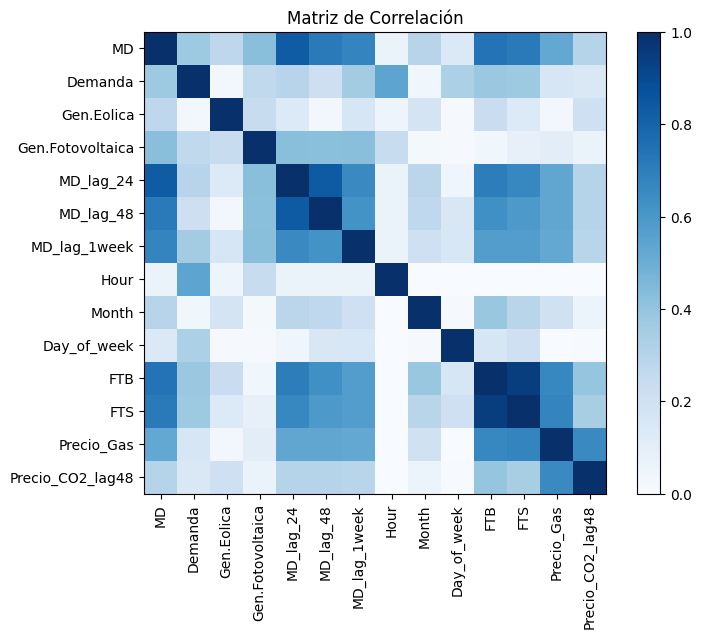

In [100]:
df_sin_fecha = df_final_futuro.drop(columns=['Datetime_hour'])

correlation_matrix = df_sin_fecha.corr()
correlation_matrix = correlation_matrix.abs()

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='Blues', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Matriz de Correlación')
plt.show()